## Trajectory Optimization of a Bouncing Ball

Explore how contact forces and discontinous dynamics can be handled in optimization. 


**Phase 1: Ball in flight**

**Phase 2: Impact**

In [141]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{ball}') # mass
hb = sym.symbols('h_{ball}') # height

# generalized coordinates
y = sym.symbols('y') 
dy = sym.symbols('\dot{y}') 
ddy = sym.symbols('\ddot{y}') 

# forces
F = sym.symbols('F_{impact}') # impulsive impact force

EOMy_1 = mb*ddy + mb*g
EOMy_1 = EOMy_1.simplify()

EOMs_1 = sym.Matrix([EOMy_1])
    
display(sym.solve(EOMs_1,ddy))

In [142]:
# # Simulate Dynamics -----------------------------------------------------------------------------------------------------------
# #initial conditions
# y0 = 1
# dy0 = 0

# h = 0.01

# #parameters
# mbval = 2
# gval = 9.81
# e = -0.8

# parameter_values = [(g,gval),(mb,mbval)]

# xar = [0]
# yar = [y0]
# dxar = [0]
# dyar = [dy0]

# N = 100
# for i in range(1,N):
    
#     # substitute parameter values and previous conditions into the EOM 
#     past = [(y,yar[i-1]),(dy,dyar[i-1])]
#     EOMs_sub = EOMs_1.subs(parameter_values).subs(past)
    
#     # solve for the acceleration
#     acc = sym.solve(EOMs_sub, ddy)
    
#     # integrate for the next velocity and position
#     # add coefficient of restitution for contact
#     if yar[i-1]<=0:
#         dyar.append(e*float(dyar[i-1]+h*acc[ddy]))
#     else:
#         dyar.append(float(dyar[i-1]+h*acc[ddy]))
#     yar.append(float(yar[i-1]+h*dyar[i]))

# xarr = np.zeros([1,N])

In [143]:
# #animate it
# import matplotlib.pyplot as plt
# import matplotlib.animation as ani
# from IPython.display import HTML
# %matplotlib inline

# fig1, ax1 = plt.subplots(1,1) #create axes
# fig1.gca().set_aspect('equal', adjustable='box') #make x,y scales equal

# def plot_board(i,x_in,y_in,ax): #update function for animation
#     ax.clear()
#     ax.set_xlim([-0.75,0.75])
#     ax.set_ylim([0,1.5])
#     ax.grid()
    
#     #plot ball
#     ballx = 0
#     bally = y_in[i]
#     ax.plot(ballx,bally,color='xkcd:black', marker='o')
    
# update = lambda i: plot_board(i,xar,yar,ax1) #lambdify update function

# animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

# HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [144]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,
            y,
            dy,
            ddy,]
            
lambEOMy = sym.lambdify(sym_list,EOMy_1,modules = [func_map])

In [145]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 60
m.N = RangeSet(N)

N1 = 30 # phase 1 - falling to the groung, end at y = 0.0

DOFs = ['y'] # generalized coordinates
m.DOF = Set(initialize = DOFs)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 2.0) # mass of board
m.e = Param(initialize = -0.8) # coefficient of restitution

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n-1,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        if n==N1:
            return Constraint.Skip # to handle change of phase 
        else:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# SWITCHING CONSTRAINT -------------------------------------------------------------------------------------------------------

def dy_switch(m,n):
    if n==N1:
        return m.dq[n,'y'] == m.e*m.dq[n-1,'y']
    else:
        return Constraint.Skip
m.dy_switch = Constraint(m.N, rule = dy_switch)

# EOMs -----------------------------------------------------------------------------------------------------------------------

def EOMy(m,n): # for y
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb,
               m.q[n,'y'], 
               m.dq[n,'y'],
               m.ddq[n,'y']] 
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

In [146]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'y'].value = 5.0
# m.q[1,'y'].fixed = True
# m.dq[1,'y'].value = 0.0
# m.dq[1,'y'].fixed = True
    
# #m.pprint()

In [147]:
# BOUNCE -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'y'].setlb(0.1)
m.dq[1,'y'].value = 0.0
m.dq[1,'y'].fixed = True

# bouncing condition, N1=30
m.q[N1,'y'].value = 0.0
m.q[N1,'y'].fixed = True

# # bouncing condition, N=N2+N
# m.q[N,'y'].value = 0.0
# m.q[N,'y'].fixed = True

In [148]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------
# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    return T
m.Cost = Objective(rule = CostFun)

In [149]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 300 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = False) 

In [150]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

ok
optimal


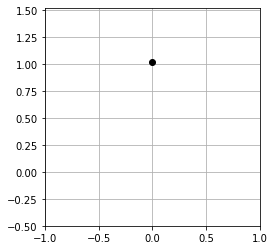

In [151]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
fig1.gca().set_aspect('equal', adjustable='box') #make x,y scales equal

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([-0.5,m.q[1,'y'].value+0.5])
    ax.grid()
    
    #plot ball
    ballx = 0.0
    bally = m.q[i,'y'].value  
    ax.plot(ballx,bally,color='xkcd:black', marker='o')
    
update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [152]:
import pickle as pkl

modelname = 'ball_elastic'+'_' + str(abs(m.e.value))
filepath = 'solutions\\'
filename = filepath+modelname
print(filename)

if (str(results.solver.termination_condition) == "optimal"):
    with open(filename, mode='wb') as file:
        pkl.dump(m, file)
        print("model saved")
else:
    print("model not saved - not optimal solution.")

solutions\ball_elastic_0.8
model saved


In [155]:
data = 'ball_elastic_1.0'
filepath = 'solutions\\'
filename = filepath+data
with open(filename, mode='rb') as file:
    m1 = pkl.load(file)

data = 'ball_elastic_0.8'
filename = filepath+data
with open(filename, mode='rb') as file:
    m2 = pkl.load(file)

data = 'ball_elastic_0.6'
filename = filepath+data
with open(filename, mode='rb') as file:
    m3 = pkl.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


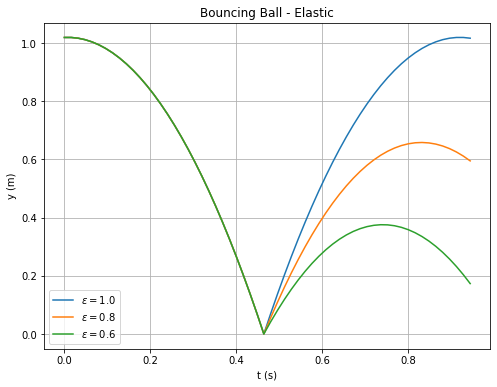

In [159]:
import matplotlib.pyplot as plt

# Plot some of the variables
yar_eps_10  = [m1.q[i,'y']() for i in range(1,N+1)]
yar_eps_08  = [m2.q[i,'y']() for i in range(1,N+1)]
yar_eps_06  = [m3.q[i,'y']() for i in range(1,N+1)]

tarr = [m.h[i]() for i in range (1,N+1)]
t = hm*np.cumsum(np.asarray(tarr))
t -= t[0]

nar = np.linspace(1,N,N)

plt.figure(figsize=(8, 6))
# plt.step(t, yar, where='post')
plt.plot(t, yar_eps_1)
plt.plot(t, yar_eps_08)
plt.plot(t, yar_eps_06)
plt.title('Bouncing Ball - Elastic')
plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.legend([r'$\epsilon = 1.0$',r'$\epsilon = 0.8$',r'$\epsilon = 0.6$'])
plt.grid(True)

plt.savefig('plots\\ball_elastic.eps', format='eps')

# plt.tight_layout()
